In [1]:
!pip install google_play_scraper
!pip install textblob
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

from google_play_scraper import app, Sort, reviews_all
from textblob import TextBlob
import string
import nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00


<ipython-input-1-656e707614c8>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# Scrap reviews from KlikDokter App on Google Play Store
klikdokter_reviews = reviews_all(
    'id.codigo.klikdokter',
    sleep_milliseconds=0,
    lang='id',  # Adjusted to Indonesian language for KlikDokter reviews
    sort=Sort.NEWEST,
)

In [3]:
# Save the reviews into a dataframe
df_klikdokter = pd.DataFrame(np.array(klikdokter_reviews), columns=['content'])
df_klikdokter = df_klikdokter.join(pd.DataFrame(df_klikdokter.pop('content').tolist()))

In [4]:
# Save the dataframe to CSV
df_klikdokter.to_csv('klikdokter_reviews.csv', index=False)
df_klikdokter.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,4b3938d7-0644-4cc2-b7ef-c312ef173d78,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Good app,5,0,None,2024-09-29 01:59:46,None,NaT,None
1,91468328-d4ab-4285-9491-88ee766615d0,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Alo dok saya mau nanya kena apa pala saya sebe...,5,0,v2.4.1,2024-09-19 09:54:51,None,NaT,v2.4.1
2,0ae499c6-a7a2-4382-aac1-1fc66364849c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"dokter nya ga mengulur waktu, langsung satset....",5,2,v2.5.3,2024-09-02 22:53:18,None,NaT,v2.5.3
3,0a668bf7-42cd-4a69-8fc3-e20fc9ddb802,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,terimakasih banyak atas informasinya,5,0,v2.5.3,2024-08-31 17:43:16,None,NaT,v2.5.3
4,b471a941-78b9-40ad-94af-a3d6668dbc59,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Menyesal aku konsultasi diaplikasi ini Udah ba...,1,0,v2.5.3,2024-08-30 01:45:35,None,NaT,v2.5.3


In [5]:
# Check the structure of the dataframe
df_klikdokter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              5712 non-null   object        
 1   userName              5712 non-null   object        
 2   userImage             5712 non-null   object        
 3   content               5712 non-null   object        
 4   score                 5712 non-null   int64         
 5   thumbsUpCount         5712 non-null   int64         
 6   reviewCreatedVersion  4235 non-null   object        
 7   at                    5712 non-null   datetime64[ns]
 8   replyContent          4173 non-null   object        
 9   repliedAt             4173 non-null   datetime64[ns]
 10  appVersion            4235 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 491.0+ KB


In [6]:
# Check unique versions of the app in reviews
print(df_klikdokter.reviewCreatedVersion.unique())
print(df_klikdokter.reviewCreatedVersion.nunique())

[None 'v2.4.1' 'v2.5.3' 'v2.5.2' 'v2.3.51' 'v2.5.1' '2.3.1' 'v2.3.6'
 '1.27.15' 'v2.3.4' '2.3.3' '2.3.0' '2.1.37' '2.2.2' '2.2.1' '2.1.60'
 '1.27.12' '2.1.50' '2.1.53' '2.1.52' '2.1.51' '2.1.41' '2.1.40' '2.1.36'
 '2.1.35' '2.0.26' '2.1.33' '2.0.38' '2.0.33' '2.0.29' '2.0.17' '2.0.13'
 '2.0.9' '1.23.20' '2.0.0' '1.20.12' '2.0.7' '2.0.5' '2.0.6' '1.23.16'
 '1.21.7' '1.27.11' '1.19.0' '1.23.19' '1.24.3' '1.21.3' '1.24.2' '1.16.0'
 '1.8.6' '1.23.15' '1.18.0' '1.23.13' '1.17.4' '1.19.3' '1.14.0' '1.14.2'
 '1.13.1' '1.15.3' '1.13.3' '1.17.2' '1.17.1' '1.6.8' '1.6.20' '1.8.1'
 '1.12.2' '1.12.7' '1.6.29' '1.6.23' '1.7.0' '1.7.3' '1.8.0' '1.8.5'
 '1.6.32' '1.3.7' '1.5.2' '1.5.15' '1.6.27' '1.6.30' '1.4.3' '1.4.7'
 '1.2.2' '1.2.5' '1.1.11' '1.3.2' '1.2.4' '1.1.20' '1.1.18' '1.1.3'
 '1.1.9' '1.1.6' '1.1.8' '1.1.5' '1.1.4' '1.1.2' '1.1.0' '1.0.7' '1.0.4'
 '1.0.2' '1.0.1' '1.0']
99


In [7]:
# Show specific columns
df_klikdokter.loc[:, ["content", "score", "thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,Good app,5,0,None,2024-09-29 01:59:46,None,NaT
1,Alo dok saya mau nanya kena apa pala saya sebe...,5,0,v2.4.1,2024-09-19 09:54:51,None,NaT
2,"dokter nya ga mengulur waktu, langsung satset....",5,2,v2.5.3,2024-09-02 22:53:18,None,NaT
3,terimakasih banyak atas informasinya,5,0,v2.5.3,2024-08-31 17:43:16,None,NaT
4,Menyesal aku konsultasi diaplikasi ini Udah ba...,1,0,v2.5.3,2024-08-30 01:45:35,None,NaT
...,...,...,...,...,...,...,...
5707,Mempermudah mngetahui tntng kshatan gaya hdup ...,5,0,1.0.1,2015-03-01 23:18:13,None,NaT
5708,Semua ulasan,5,0,None,2015-02-27 14:02:54,None,NaT
5709,BAguz,4,0,None,2015-02-27 03:45:35,"Hai Akbar M, terima kasih telah menggunakan ap...",2018-09-27 09:26:29
5710,Mempermudah kita jika mau berkonsultasi dengan...,5,0,None,2015-02-19 03:33:44,None,NaT


In [8]:
!pip install emoji

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.2/553.2 kB 8.3 MB/s eta 0:00:00


In [9]:
# Sentiment analysis using TextBlob
df_klikdokter['sentiment_polarity'] = df_klikdokter['content'].apply(lambda x: TextBlob(x).polarity)
df_klikdokter['sentiment_subjective'] = df_klikdokter['content'].apply(lambda x: TextBlob(x).subjectivity)

In [10]:
df_klikdokter.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
0,Good app,5,0.700000,0.600000
1,Alo dok saya mau nanya kena apa pala saya sebelah kiri sape kepundak selalu sakit terus kena apa iya dok,5,0.000000,0.000000
2,"dokter nya ga mengulur waktu, langsung satset. ga kaya app lain yg dokter nya bru bals wktu udh mendekati akhir sesi",5,0.000000,0.000000
3,terimakasih banyak atas informasinya,5,0.000000,0.000000
4,Menyesal aku konsultasi diaplikasi ini Udah bayar tapi gagal menghubungkan Udah gitu uang tidak kembali keshopeepay malah jd voucher mana vouchernya gak bisa dipakai selain kedokter spesialis KALI...,1,0.000000,0.000000
...,...,...,...,...
5707,Mempermudah mngetahui tntng kshatan gaya hdup yg benar,5,0.000000,0.000000
5708,Semua ulasan,5,0.000000,0.000000
5709,BAguz,4,0.000000,0.000000
5710,Mempermudah kita jika mau berkonsultasi dengan dokter. Keren :),5,0.500000,1.000000


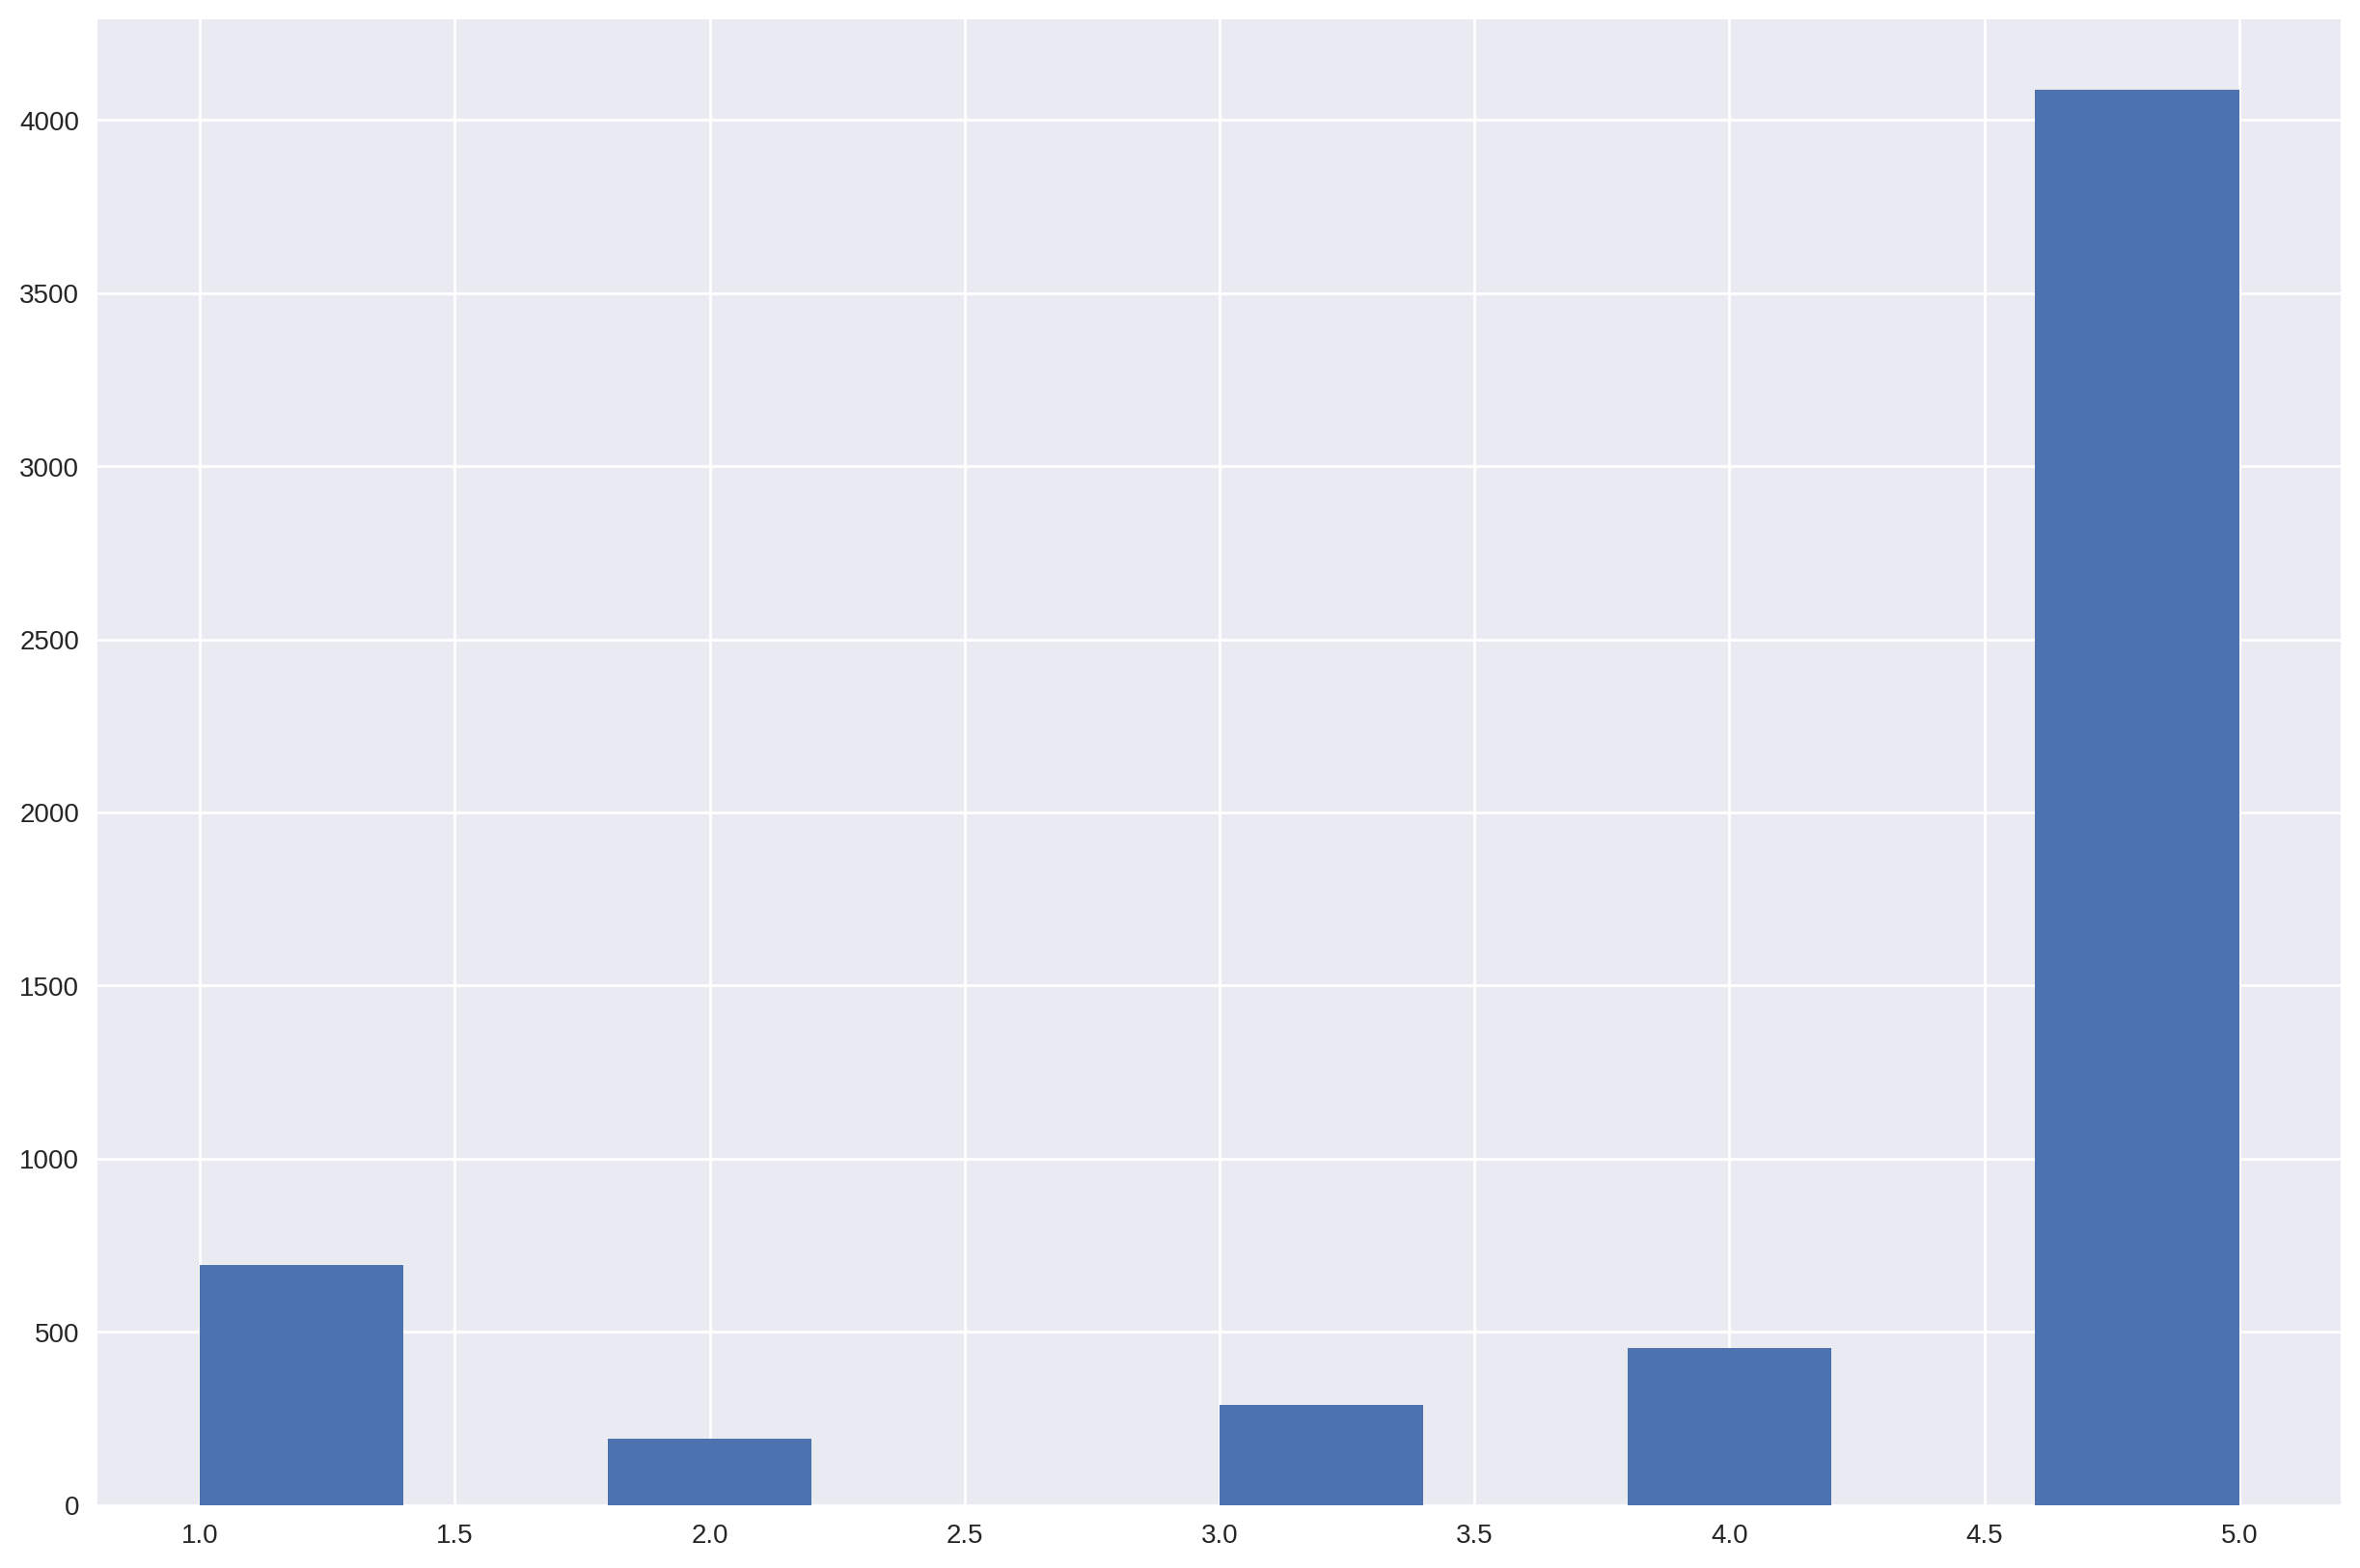

In [11]:
# Plot histogram of review scores
plt.hist(df_klikdokter['score'])
plt.show()

In [12]:
# Data preprocessing
df_klikdokter['content'] = df_klikdokter['content'].astype(str).apply(lambda x: x.lower())
print(df_klikdokter['content'][2])

dokter nya ga mengulur waktu, langsung satset. ga kaya app lain yg dokter nya bru bals wktu udh mendekati akhir sesi


In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# Count word length, uppercase characters, and special characters
df_klikdokter['wordCount'] = df_klikdokter['content'].apply(lambda x: len(x.split()))
df_klikdokter['uppercaseCharCount'] = df_klikdokter['content'].apply(lambda x: sum(c.isupper() for c in x))
df_klikdokter['specialCharCount'] = df_klikdokter['content'].apply(lambda x: sum(c in string.punctuation for c in x))

In [15]:
df_klikdokter.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,good app,5,0.700000,0.600000,2,0,0
1,alo dok saya mau nanya kena apa pala saya sebelah kiri sape kepundak selalu sakit terus kena apa iya dok,5,0.000000,0.000000,20,0,0
2,"dokter nya ga mengulur waktu, langsung satset. ga kaya app lain yg dokter nya bru bals wktu udh mendekati akhir sesi",5,0.000000,0.000000,21,0,2
3,terimakasih banyak atas informasinya,5,0.000000,0.000000,4,0,0
4,menyesal aku konsultasi diaplikasi ini udah bayar tapi gagal menghubungkan udah gitu uang tidak kembali keshopeepay malah jd voucher mana vouchernya gak bisa dipakai selain kedokter spesialis kali...,1,0.000000,0.000000,37,0,0
...,...,...,...,...,...,...,...
5707,mempermudah mngetahui tntng kshatan gaya hdup yg benar,5,0.000000,0.000000,8,0,0
5708,semua ulasan,5,0.000000,0.000000,2,0,0
5709,baguz,4,0.000000,0.000000,1,0,0
5710,mempermudah kita jika mau berkonsultasi dengan dokter. keren :),5,0.500000,1.000000,9,0,3


In [ ]:
#Removing stopwords
#Using nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

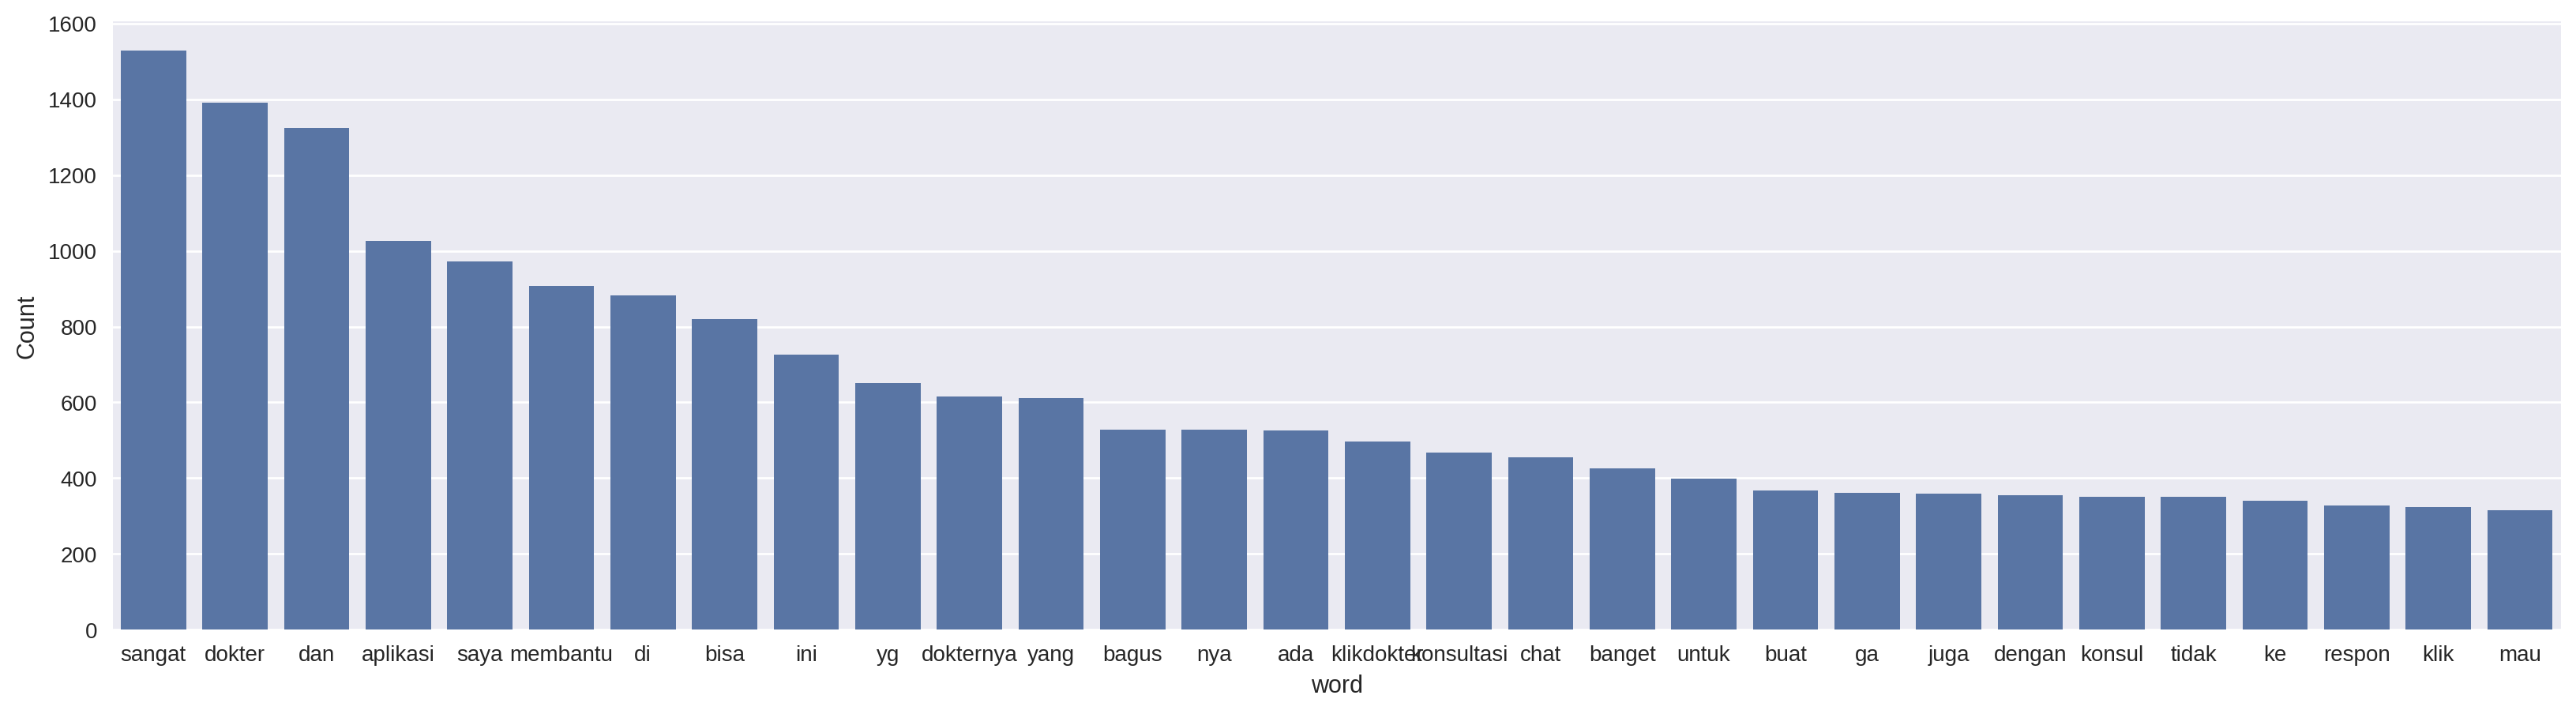

In [ ]:
freq_words(df_klikdokter['content'])

In [ ]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(df_klikdokter.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
    expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return expe.findall(s)
    return expe.sub(r'',s)

for y in df_klikdokter['content']:
    #print(str(extract_emojis(y)))
    extracted_emojis.append(str(extract_emojis(y)))

print(extracted_emojis)

True
['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍']", '[]', '[]', "['🤷', '🏻']", "['😮', '💨', '😮', '💨', '😮', '💨']", '[]', '[]', "['👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🙏']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🥰']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🩹']", '[]', '[]', '[]', "['🙏']", '[]', '[]', '[]', '[]', "['😄', '😊']", '[]', '[]', '[]', '[]', '[]', "['😒']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🙏']", '[]', '[]', '[]', "['👍', '👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', 

In [ ]:
df_klikdokter.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,"dokter nya ga mengulur waktu, langsung satset. ga kaya app lain yg dokter nya bru bals wktu udh mendekati akhir sesi",5,0.000000,0.000000,21,0,2
1,terimakasih banyak atas informasinya,5,0.000000,0.000000,4,0,0
2,menyesal aku konsultasi diaplikasi ini udah bayar tapi gagal menghubungkan udah gitu uang tidak kembali keshopeepay malah jd voucher mana vouchernya gak bisa dipakai selain kedokter spesialis kali...,1,0.000000,0.000000,37,0,0
3,aplikasi dalam pembayaran ngebug saya udah bayar tapi malah ngebug trus proses pengembalian dana butuh waktu lama 5 menit aja nggak ada butuh waktu beberapa jam,1,0.000000,0.000000,26,0,0
4,"aplikasi ini sangat tidak membantu ,dokternya pelit ilmu,durasi sedikit tidak mau menjelaskan dengan panjang. dokternya tidak rekomendasi",1,0.000000,0.000000,17,0,3
...,...,...,...,...,...,...,...
5705,mempermudah mngetahui tntng kshatan gaya hdup yg benar,5,0.000000,0.000000,8,0,0
5706,semua ulasan,5,0.000000,0.000000,2,0,0
5707,baguz,4,0.000000,0.000000,1,0,0
5708,mempermudah kita jika mau berkonsultasi dengan dokter. keren :),5,0.500000,1.000000,9,0,3


In [ ]:
# Add sentiment rating
df_klikdokter['sentiment_rating'] = df_klikdokter['score'].apply(lambda x: 'Positive' if x > 3 else ('Neutral' if x == 3 else 'Negative'))

In [ ]:
df_klikdokter.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,"dokter nya ga mengulur waktu, langsung satset. ga kaya app lain yg dokter nya bru bals wktu udh mendekati akhir sesi",5,0.000000,0.000000,Positive
1,terimakasih banyak atas informasinya,5,0.000000,0.000000,Positive
2,menyesal aku konsultasi diaplikasi ini udah bayar tapi gagal menghubungkan udah gitu uang tidak kembali keshopeepay malah jd voucher mana vouchernya gak bisa dipakai selain kedokter spesialis kali...,1,0.000000,0.000000,Negative
3,aplikasi dalam pembayaran ngebug saya udah bayar tapi malah ngebug trus proses pengembalian dana butuh waktu lama 5 menit aja nggak ada butuh waktu beberapa jam,1,0.000000,0.000000,Negative
4,"aplikasi ini sangat tidak membantu ,dokternya pelit ilmu,durasi sedikit tidak mau menjelaskan dengan panjang. dokternya tidak rekomendasi",1,0.000000,0.000000,Negative
...,...,...,...,...,...
5705,mempermudah mngetahui tntng kshatan gaya hdup yg benar,5,0.000000,0.000000,Positive
5706,semua ulasan,5,0.000000,0.000000,Positive
5707,baguz,4,0.000000,0.000000,Positive
5708,mempermudah kita jika mau berkonsultasi dengan dokter. keren :),5,0.500000,1.000000,Positive


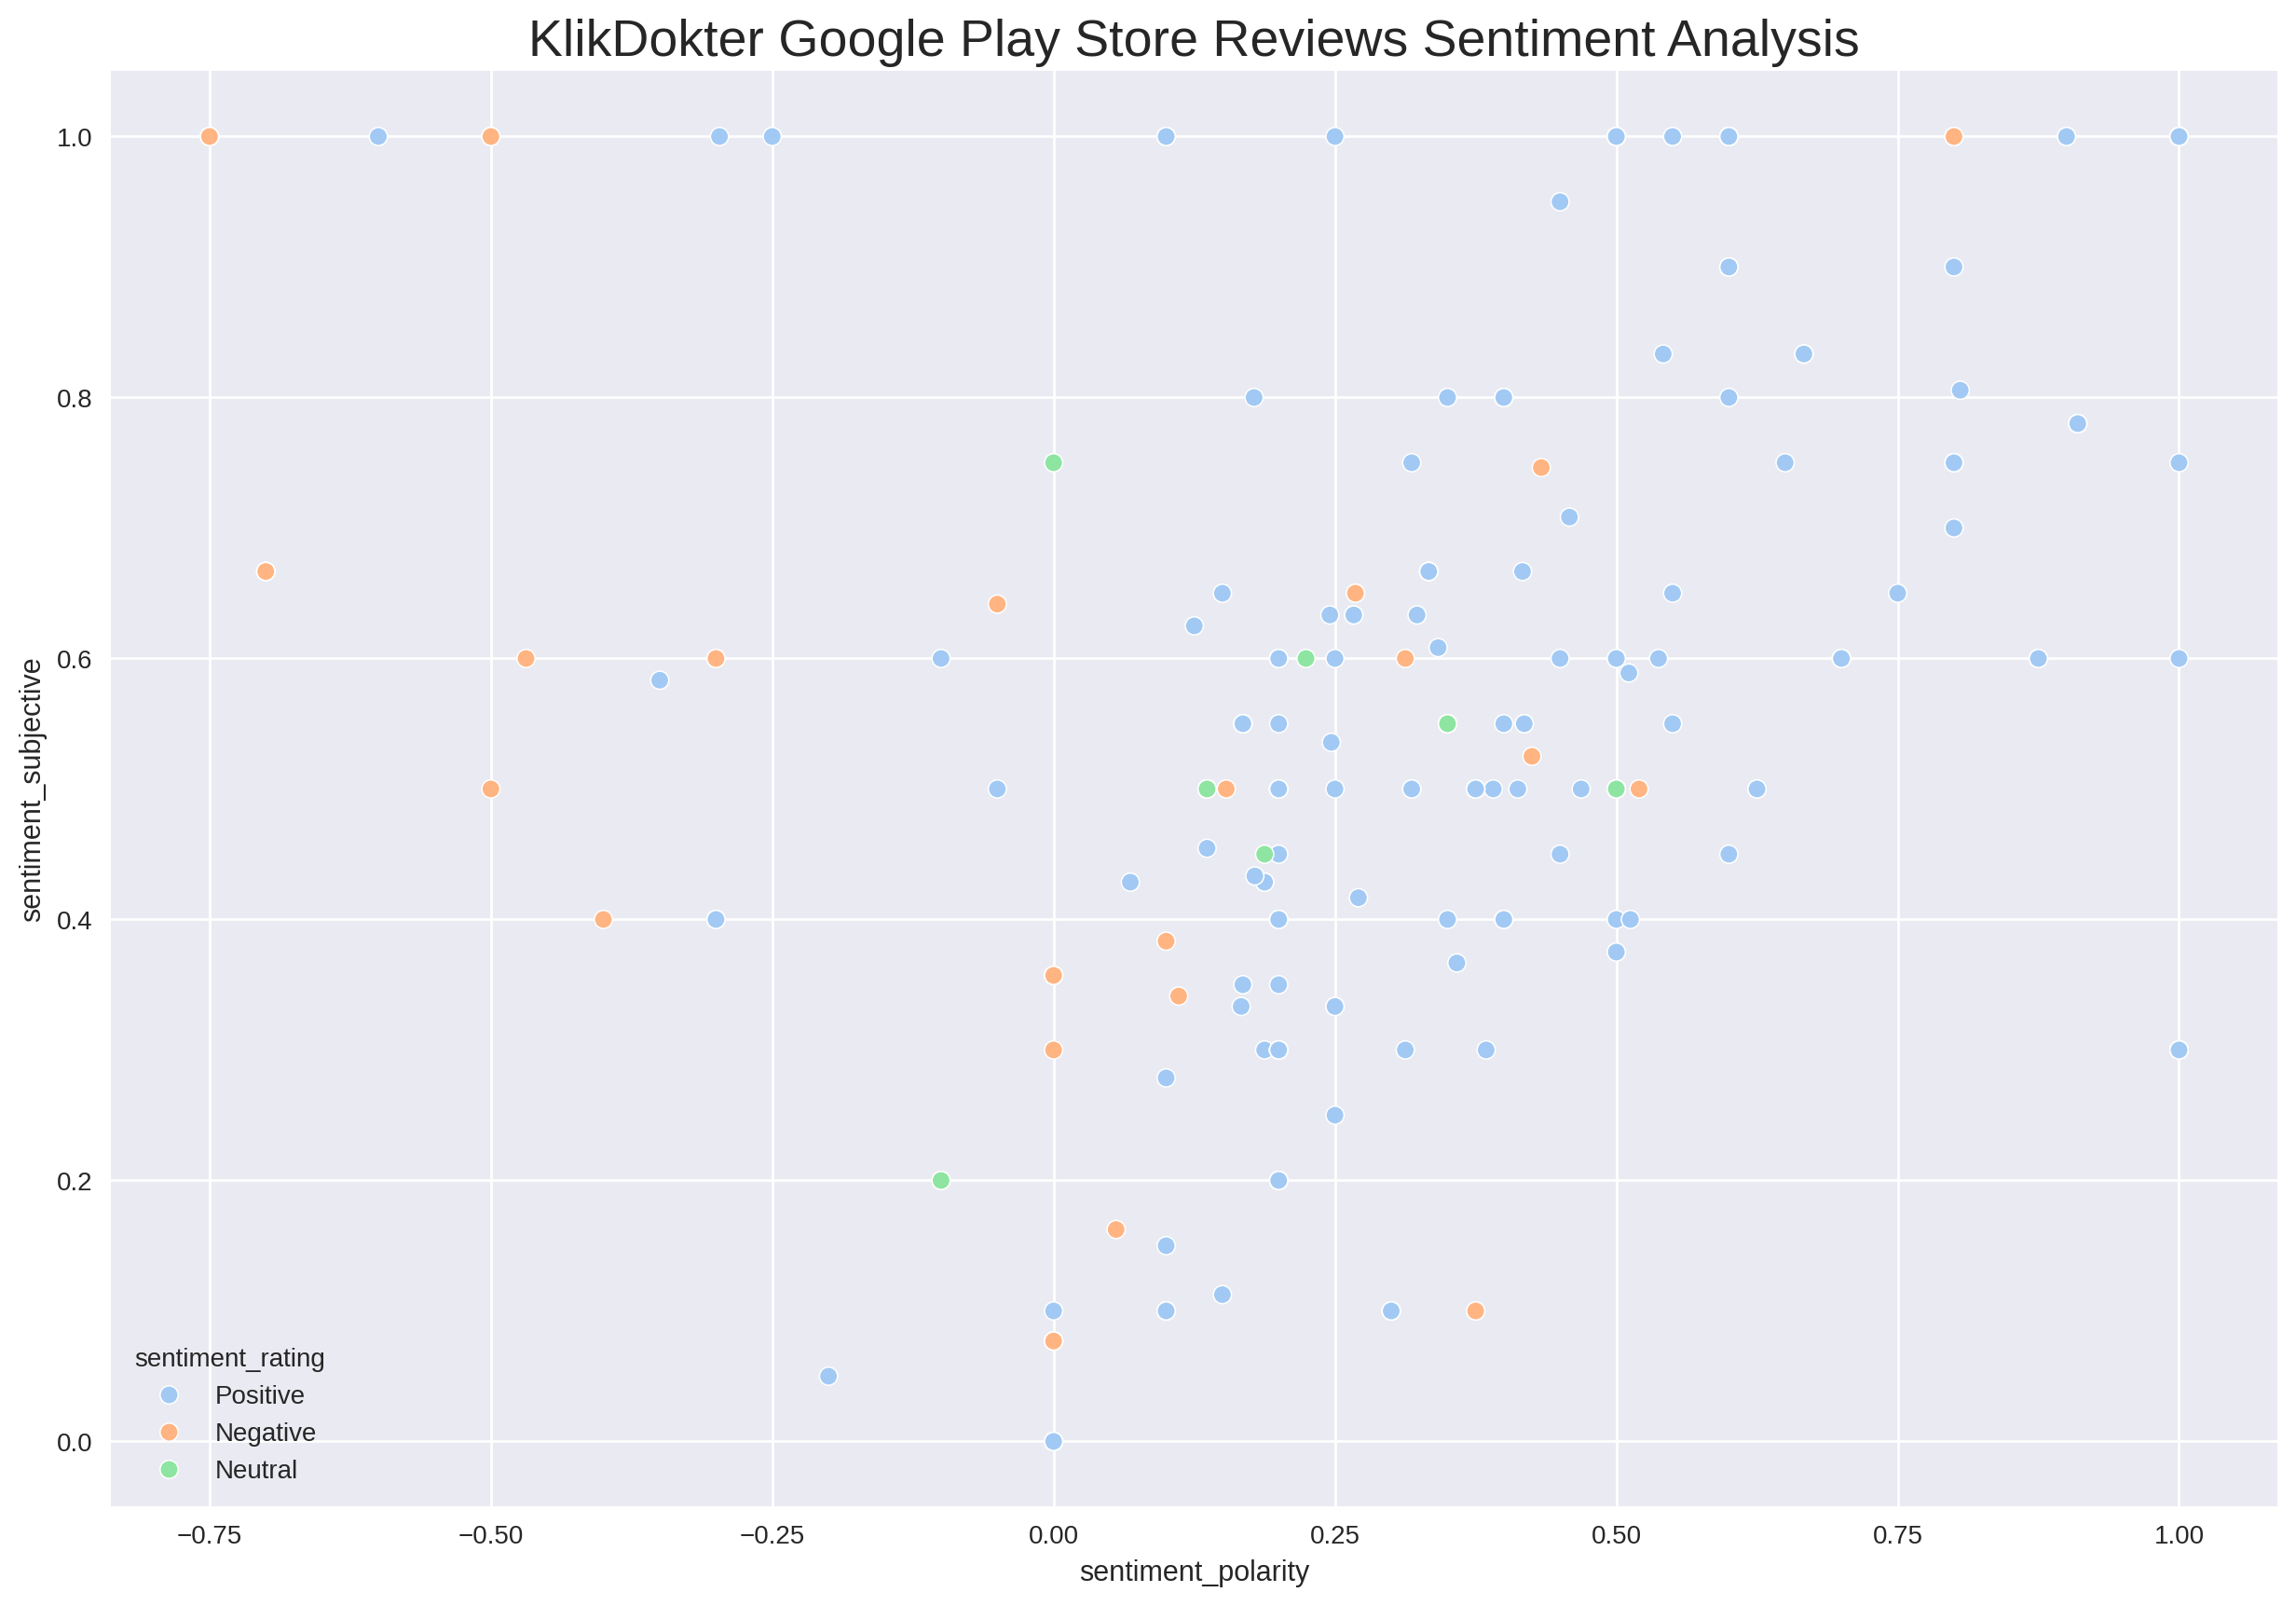

In [ ]:
# Scatter plot of sentiment polarity vs subjectivity
plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_klikdokter['sentiment_polarity'], y=df_klikdokter['sentiment_subjective'],
                hue=df_klikdokter['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("KlikDokter Google Play Store Reviews Sentiment Analysis", fontsize=20)
plt.show()


In [ ]:
# Save to CSV after sentiment analysis
df_klikdokter.to_csv(r'klikdokter_reviews_sentiment.csv', index=False)

In [ ]:
# Remove stopwords
nltk.download('stopwords')
stop = stopwords.words('indonesian') + ["seseorang", "masih", "akan", "perlu"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Apply stopwords removal
df_klikdokter['content_without_stopwords'] = df_klikdokter['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# Save the processed data
df_klikdokter.to_csv(r'klikdokter_reviews_processed.csv', index=False)

In [ ]:
# Print example of processed content
print(df_klikdokter['content_without_stopwords'].head())

0                                                                                        dokter nya ga mengulur waktu, langsung satset. ga kaya app yg dokter nya bru bals wktu udh mendekati sesi
1                                                                                                                                                                         terimakasih informasinya
2    menyesal konsultasi diaplikasi udah bayar gagal menghubungkan udah gitu uang keshopeepay jd voucher vouchernya gak dipakai kedokter spesialis coba coba deh instal aplikasi mending alodokter
3                                                                                     aplikasi pembayaran ngebug udah bayar ngebug trus proses pengembalian dana butuh 5 menit aja nggak butuh jam
4                                                                                                                    aplikasi membantu ,dokternya pelit ilmu,durasi panjang. dokternya rekomendasi
Name: content_without_sto

In [ ]:
import re
import pandas as pd

In [ ]:
# Fungsi untuk membersihkan karakter selain huruf dan angka
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Hapus karakter spesial
    return text

In [ ]:
# Fungsi untuk menghapus emoji
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticon
                           u"\U0001F300-\U0001F5FF"  # simbol & pictograf
                           u"\U0001F680-\U0001F6FF"  # transport & simbol
                           u"\U0001F1E0-\U0001F1FF"  # bendera (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
# Fungsi untuk normalisasi teks
def normalize_text(text):
    text = text.lower()  # Huruf kecil
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    return text

In [ ]:
# Fungsi untuk menghapus URL
def remove_urls(text):
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    return url_pattern.sub(r'', text)

In [ ]:
# Terapkan semua preprocessing ke kolom 'content'
df_klikdokter['cleaned_content'] = df_klikdokter['content'].apply(clean_text)
df_klikdokter['content_without_emoji'] = df_klikdokter['cleaned_content'].apply(remove_emojis)
df_klikdokter['normalized_content'] = df_klikdokter['content_without_emoji'].apply(normalize_text)
df_klikdokter['final_content'] = df_klikdokter['normalized_content'].apply(remove_urls)

# Menampilkan dataframe hasil preprocessing
df_klikdokter[['content', 'final_content']].head()

,content,final_content
0,Alo dok saya mau nanya kena apa pala saya sebe...,alo dok saya mau nanya kena apa pala saya sebe...
1,"dokter nya ga mengulur waktu, langsung satset....",dokter nya ga mengulur waktu langsung satset g...
2,terimakasih banyak atas informasinya,terimakasih banyak atas informasinya
3,Menyesal aku konsultasi diaplikasi ini Udah ba...,menyesal aku konsultasi diaplikasi ini udah ba...
4,Aplikasi dalam pembayaran ngebug saya udah bay...,aplikasi dalam pembayaran ngebug saya udah bay...
